<a href="https://colab.research.google.com/github/YarinBeni/Guided--Project--Yedid-Barak/blob/main/ArchaeologyLettersRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instructions For Yarin:
1. drag and drop a ziped folder named "Database - Copy.zip" of the data in this colab folders in path /content/HERE (located in https://drive.google.com/drive/folders/1RZWxjr8cXaWmjOspGbIPFmN1TVrVSIYX?usp=sharing_eip_m&ts=642c12f4)
2. wait for upload to be finished
3. run the code cell by cell (Ignore the Cell with TEST in there title).

# Future Tasks:
1a) find relevant degradation for the model: 
  possible list of ideas:
   invraint to: camera position,random cracks, old photo filter, random deletes(random crops),random lighting(normalization?) *--DONE*

1b) future test combination of best degradations as did in "Simclr" paper? *--DONE*

2) figure out how to train on gpu local or in googlecolab --DONE

3) understand how pytorch experiments and weights and baiss from FSDL Lab02 and lab04

4) start model training

5) make sure overfit on single batch --DONE

6) expand to 100 epochs and check results on maybe another models




# Letter Recognition in Archaeology Writing using Deep Learning

## Project Overview
This project aims to address the unique challenge of letter recognition in archaeological writings through the implementation of deep learning techniques. Our methodology is based on a self-supervised approach for multi-class classification. 

Our goal is to aid archaeologists and researchers in understanding ancient scripts more effectively, thereby unlocking the potential for significant historical insights. 

## How to Run this Notebook

1. **Set up the Environment**: Ensure that you have all the necessary libraries installed. You can do this by running the cell titled 'Install required libraries'.

2. **Import the Dataset**: You need to import your dataset into this Colab notebook. Upload the dataset to your Google Drive and mount the drive to access the files from this notebook.

3. **Preprocess the Data**: Run the cells under the 'Data Preprocessing' section. This will prepare the dataset for the deep learning model.

4. **Train the Model**: Execute the cells under the 'Model Training' section. This will initiate the training of the deep learning model on the preprocessed dataset.

5. **Evaluate the Model**: After the model has been trained, run the 'Model Evaluation' cells to see how well the model performs.

6. **Apply the Model**: Finally, you can use the trained model to classify letters in archaeological writings. Run the 'Application' cells to use the model.

**Note:** This notebook is set up to be run from top to bottom. Running cells out of order may result in errors.

Enjoy exploring and don't hesitate to reach out if you have any questions or encounter any issues!


#*Install Packages:*

In [ ]:
!pip install pytorch_lightning lightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.7/653.7 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=56f4788dc45c8576d4b5102d1c267a25c865b79cbeb6ca426b1a8b6d04043159
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


#*Drop Database ziped Folder into relvent Path By code in the cell and run cell:*

In [ ]:
from zipfile import ZipFile
file_name = "/content/Database - Copy.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


#*Create Dataset with DataBaseFactory Class:*

In [ ]:
import cv2
import json
import numpy as np
import os
import pandas as pd


class DatabaseFactory:
    def __init__(self, data_path):
        self.samples_data = {}
        self.original_images_data = {}
        self.samples_amount = 0

        for dirpath, dirnames, filesnames in os.walk(data_path):  # search in database folder
            if filesnames:  # means there is photos in the folder
                self.image_info = {}
                self.parser_image_file(filesnames)
                self.parse_json_file(dirpath, filesnames)
        self.save_samples_data_to_csv()

    def save_samples_data_to_csv(self):
        df1 = pd.DataFrame.from_dict(self.samples_data, orient='index')
        df1.to_csv('samples_database.csv')

        df2 = pd.DataFrame.from_dict(self.original_images_data, orient='index')
        df2.to_csv('original_images_database.csv')

    def parse_json_file(self, dirpath, filesnames):
        for filename in filesnames:
            if filename.endswith("json"):
                print(f"this is image number: {self.samples_amount}, file name: {filename}\n")
                self.image_info["original_folder_path"] = dirpath
                self.image_info["json_name"] = "/" + filename

                print("Path Name made by CODE: ",self.image_info["original_folder_path"] + self.image_info["json_name"])
                print("Path Name in FOLDER and Path Name made by CODE are the same: ",
                      self.image_info["original_folder_path"] + self.image_info["json_name"]==
                      "/content/Database - Copy/Arad (end of 7th century Judah)/Arad24_1972-121_I-86564_3200dpi_16b/testjson.json")
                
                with open(self.image_info["original_folder_path"] + self.image_info["json_name"], 'r') as f:
                    self.data = json.load(f)
                    f.close()
                for i in range((len(self.data['annotations'][0]['result']))):
                    self.parser_image_info(i)

                    cropped = self.get_polygon_crop()
                    if not os.path.exists(self.image_info["original_folder_path"] + "\\Samples"):
                        os.makedirs(self.image_info["original_folder_path"] + "\\Samples")

                    self.new_sample_info = {}
                    self.fill_new_sample_info()
                    if self.image_info:
                        self.samples_data[self.samples_amount] = self.new_sample_info
                        self.original_images_data[self.image_info["original_folder_path"]] = self.image_info
                    self.samples_amount += 1
                    cv2.imwrite(self.new_sample_info["sample_path"], cropped)

    def parser_image_file(self, filesnames):
        for filename in filesnames:
            if filename.endswith("png"):
                self.image_info["original_image_name"] = "/" + filename

    def fill_new_sample_info(self):
        self.new_sample_info["sample_name"] = str(self.samples_amount)
        self.new_sample_info["from_image"] = self.image_info["original_image_name"][1:]
        self.new_sample_info["from_area"] = self.image_info["original_folder_path"].rsplit("/", 3)[-2]
        self.new_sample_info["sample_path"] = self.image_info["original_folder_path"] + "/Samples/" \
                                              + self.new_sample_info["sample_name"] + '.png'
        self.new_sample_info["label"] = self.new_sample_info["from_area"] + "_-_" + self.new_sample_info[
            "from_image"]

    def parser_image_info(self, i):
        self.image_info['points'] = self.data['annotations'][0]['result'][i]['value']['points']
        self.image_info['width'] = self.data['annotations'][0]['result'][i]["original_width"]
        self.image_info['height'] = self.data['annotations'][0]['result'][i]["original_height"]
        self.image_info['scaled_points'] = np.array(
            [[int(x / 100.0 * self.image_info['width']), int(y / 100.0 * self.image_info['height'])]
             for x, y in self.image_info['points']], dtype=np.int32)

    def annotate_image(self):
        pass
        # scaled_points = self.get_scaled_points()
        # cv2.polylines(self.image, [scaled_points], True, (0, 255, 0), thickness=20)
        # cv2.imshow('image', self.image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

    def rectangle_crop_and_show(self):
        pass
        # x, y, w, h = cv2.boundingRect(np.array([self.scaled_points], dtype=np.int32))
        # cropped = self.image[y:y + h, x:x + w]
        # cv2.imshow('Cropped Image', cropped)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()

    def get_polygon_crop(self):
        #print("in get_polygon_crop: ",self.image_info["original_folder_path"] + self.image_info["original_image_name"])
        image = cv2.imread(self.image_info["original_folder_path"] + self.image_info["original_image_name"])
        x, y, w, h = cv2.boundingRect(np.array([self.image_info['scaled_points']], dtype=np.int32))
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        cv2.fillPoly(mask, [self.image_info['scaled_points']], 255)
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        cropped = masked_image[y:y + h, x:x + w]
        cropped[mask[y:y + h, x:x + w] == 0] = 255
        return cropped
DatabaseFactory(r"/content/Database - Copy")


this is image number: 0, file name: 1951 5 json.json

Name made by CODE:  /content/Database - Copy/Ajrud (first half of 8th century - Sinai desert)/1951 5/1951 5 json.json
Name in FOLDER:  /content/Database - Copy/Arad (end of 7th century Judah)/Arad24_1972-121_I-86564_3200dpi_16b/testjson.json
this is image number: 25, file name: 9 json.json

Name made by CODE:  /content/Database - Copy/Ajrud (first half of 8th century - Sinai desert)/9/9 json.json
Name in FOLDER:  /content/Database - Copy/Arad (end of 7th century Judah)/Arad24_1972-121_I-86564_3200dpi_16b/testjson.json
this is image number: 28, file name: 2 json.json

Name made by CODE:  /content/Database - Copy/Ajrud (first half of 8th century - Sinai desert)/2/2 json.json
Name in FOLDER:  /content/Database - Copy/Arad (end of 7th century Judah)/Arad24_1972-121_I-86564_3200dpi_16b/testjson.json
this is image number: 47, file name: Lachish_1938 jason.json

Name made by CODE:  /content/Database - Copy/Lachish (end of 7th century Judah

#*Initialize CustomDataset Class:*#

In [ ]:
import math
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
import cv2
import torch
import pandas as pd
import torch.nn.functional as F

#######################################################
#                  Create Dataset
#######################################################
DIC_NAME = "dic_name"
FOLDER_PATH = "folder_path"
worms_params = {
    # "batch_size": 2,  # the number of image per sample check if need to be changed -A: FOR NOW ITS FINE !
    "num_workers": 4,
    "image_max_size": (0, 0),
    "in_channels": 1,  # to make sure because its gray image 1 channel or maybe 3 from tensor size? -A: YES
    "num_classes": None  # to make sure we dont have classes because our label is an image -A: EXACTLY !
}
#CSV_DATASET_PATH = r"C:\Users\yarin\PycharmProjects\GuidedProject\samples_database.csv"
CSV_DATASET_PATH ="/content/samples_database.csv"

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform_dic={}):
        self.image_pad_param = self.get_max_image_size(image_paths.rsplit("\\", 1)[0] + "\\Database")
        self.image_paths = pd.read_csv(image_paths)
        self.transform_dic = transform_dic

    def __len__(self):
        return self.image_paths.shape[0]

    def __getitem__(self, index):
        metadata_sample = self.image_paths.loc[index]
        dic_image = torch.from_numpy(cv2.resize(cv2.imread(metadata_sample["sample_path"], 1), (384, 384))).permute(2,0,1).float()
        # dic_image = self.pad_sample(dic_image)

        # Add a resize operation to the transformation pipeline
        # dic_image = F.interpolate(dic_image, size=(3,384, 384))


        return dic_image[None,:,:], dict(metadata_sample)
        #return dic_image[None,:,:],dic_image[None,:,:]

    def pad_sample(self, dic):
        if self.image_pad_param[0] == 0 and self.image_pad_param[1] == 0:
            return dic
        new_image_height, new_image_width = self.image_pad_param
        old_image_height, old_image_width = dic.shape[0], dic.shape[1]
        w_pad = new_image_width - old_image_width
        h_pad = new_image_height - old_image_height

        if w_pad % 2 != 0:
            w1_pad = int(math.ceil(w_pad / 2)) - 1
            w2_pad = int(math.ceil(w_pad / 2))
        else:
            w1_pad = int(math.ceil(w_pad / 2))
            w2_pad = int(math.ceil(w_pad / 2))

        if h_pad % 2 != 0:
            h1_pad = int(math.ceil(h_pad / 2)) - 1
            h2_pad = int(math.ceil(h_pad / 2))
        else:
            h1_pad = int(math.ceil(h_pad / 2))
            h2_pad = int(math.ceil(h_pad / 2))

        pad_image = torch.nn.ConstantPad2d((w1_pad, w2_pad, h1_pad, h2_pad), 255)(dic.permute(2, 0, 1))
        pad_image = pad_image.permute(0, 1,2)

        return pad_image

    def get_max_image_size(self, data_path):
        max_h, max_w = 0, 0

        for dirpath, dirnames, filenames in os.walk(data_path):
            if filenames and dirpath.rsplit("\\", 1)[1] == 'Samples':
                for filename in filenames:
                    if filename.endswith('.png'):
                        filepath = os.path.join(dirpath, filename)
                        img = cv2.imread(filepath)
                        h, w = img.shape[:2]
                        if h > max_h:
                            max_h = h
                        if w > max_w:
                            max_w = w
        return max_h, max_w

#*Initialize Dino Model:*#

In [ ]:
# Note: The model and training settings do not follow the reference settings
# from the paper. The settings are chosen such that the example can easily be
# run on a small dataset with a single GPU.

import copy

import pytorch_lightning as pl
import torch
import torchvision
from torch import nn

from lightly.data import LightlyDataset
from lightly.data.multi_view_collate import MultiViewCollate
from lightly.loss import DINOLoss
from lightly.models.modules import DINOProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.dino_transform import DINOTransform
from lightly.utils.scheduler import cosine_schedule


class DINO(pl.LightningModule):
    def __init__(self,lr=0.001):
        super().__init__()
        #resnet = torchvision.models.resnet18()
        # backbone = nn.Sequential(*list(resnet.children())[:-1])
        # input_dim = 512
        # instead of a resnet you can also use a vision transformer backbone as in the
        # original paper (you might have to reduce the batch size in this case):
        backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits16', pretrained=True)
        input_dim = backbone.embed_dim
        self.lr=lr
        self.printed_epoch = -1
        self.student_backbone = backbone
        self.student_head = DINOProjectionHead(
            input_dim, 512, 64, 2048, freeze_last_layer=1
        )
        self.teacher_backbone = copy.deepcopy(backbone)
        self.teacher_head = DINOProjectionHead(input_dim, 512, 64, 2048)
        deactivate_requires_grad(self.teacher_backbone)
        deactivate_requires_grad(self.teacher_head)

        self.criterion = DINOLoss(output_dim=2048, warmup_teacher_temp_epochs=5)

    def forward(self, x):
        y = self.student_backbone(x).flatten(start_dim=1)
        z = self.student_head(y)
        return z

    def forward_teacher(self, x):
        y = self.teacher_backbone(x).flatten(start_dim=1)
        z = self.teacher_head(y)
        return z

    def training_step(self, batch, batch_idx):
        momentum = cosine_schedule(self.current_epoch, 50, 0.996, 1)
        update_momentum(self.student_backbone, self.teacher_backbone, m=momentum)
        update_momentum(self.student_head, self.teacher_head, m=momentum)
        views, _, _ = batch
        views = [view.to(self.device) for view in views]
        global_views = views[:2]
        teacher_out = [self.forward_teacher(view) for view in global_views]
        student_out = [self.forward(view) for view in views]
        loss = self.criterion(teacher_out, student_out, epoch=self.current_epoch)
        if self.printed_epoch < self.current_epoch:
          self.printed_epoch+=1
          print(f"Training loss on Epoch {self.current_epoch}: {loss}")
          
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        views, _, _ = batch
        views = [view.to(self.device) for view in views]
        global_views = views[:2]
        teacher_out = [self.forward_teacher(view) for view in global_views]
        student_out = [self.forward(view) for view in views]
        loss = self.criterion(teacher_out, student_out, epoch=self.current_epoch)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        if(self.current_epoch==19):
          print()
          print(f"Validation loss on Epoch {self.current_epoch}: {loss}")
          print()


    def on_after_backward(self):
        self.student_head.cancel_last_layer_gradients(current_epoch=self.current_epoch)

    def configure_optimizers(self):
        optim = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optim
    @property
    def backbone(self):
      return self.student_backbone  # or self.teacher_backbone, depending on what you need



# *Create Augmentations*:
When choosing the augmentations, you should keep in mind the characteristics of the problem. we are working with archaeology writing which could likely be affected by camera position, random cracks, "old photo" effects, random deletions (crops), and random lighting. Here are some suggestions on how you can handle these:

1. **Camera Position:** We can simulate the effect of changing camera position by transformations such as rotation and shearing. Torchvision provides transforms like `torchvision.transforms.RandomRotation` and `torchvision.transforms.RandomAffine` (which can handle shearing) **-We will use the first**.

2. **Random Cracks:** Simulating cracks could be a bit tricky. we might consider a custom transformation that randomly applies lines (cracks) on the image. Another option could be using `torchvision.transforms.RandomErasing` which randomly "erases" rectangular areas in the image **-We will not use it for now**.

3. **Old Photo Effect:** This usually involves changing the color balance of the image to give it a "faded" look, and possibly adding noise. We could use `torchvision.transforms.ColorJitter` to alter the color balance and `torchvision.transforms.Lambda` to apply a custom function that adds noise to the image **-We will use the first**.

4. **Random Deletes (Random Crops):** You can use `torchvision.transforms.RandomResizedCrop` which randomly crops the image and then resizes it back to the original size **-We will use it**. 

5. **Random Lighting:** `torchvision.transforms.ColorJitter` can be used to simulate changes in brightness, which can mimic the effect of different lighting conditions **-We will use it**.

Here's how I define these transformations using DINOtransform from lightly.ai:


In [ ]:
import torch
from lightly.transforms.dino_transform import DINOTransform

# caculate std and mean for normalize for DINOtransform
def calculate_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0.
    for data, _ in loader:  # assuming your dataset returns a tuple of (data, label)
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

custom_pytorch_dataset = CustomDataset(CSV_DATASET_PATH)
transform = DINOTransform()
dataset = LightlyDataset.from_torch_dataset(custom_pytorch_dataset, transform=transform)
mean, std = calculate_mean_std(custom_pytorch_dataset)
print(f'Mean: {mean}, Std: {std}')

transform= DINOTransform(
    global_crop_size=224, 
    global_crop_scale=(0.08, 1.0),  # ~RandomResizedCrop
    local_crop_size=96,  # Smaller crop for the local view
    local_crop_scale=(0.05, 0.4),  # Smaller scale for the local view
    n_local_views=6,  # 

    hf_prob=0,  # NO ~Horizontal Flip
    vf_prob=0,  # NO ~Vertical Flip for additional invariance
    
    rr_prob=0.5,  # ~Random Rotation
    rr_degrees=(0, 360),  # Rotate randomly between 0 and 360 degree
    
    cj_prob=0.8,  # ~Color Jitter
    cj_strength=0.5,  
    cj_bright=0.8,  # to simulate the changing light
    cj_contrast=0.8,  #to simulate old photo effect
    random_gray_scale=0.2,  # Convert to grayscale with a small probability
    gaussian_blur=(0.1, 0.5, 0.5),  # Apply gaussian blur with some probability
    sigmas=(0.1, 2.0),  # Adjust these values based on your dataset
    solarization_prob=0.2,  # Apply solarization with some probability
    normalize={'mean': mean, 'std': std}  # Normalization values for ImageNet, adjust if necessary
)





Mean: tensor([175.9199, 175.9199, 175.9199]), Std: tensor([70.3644, 70.3644, 70.3644])


#*Test Overfit on a Single Batch*:

In [ ]:
#TEST OVERFIT single Batch

import pytorch_lightning as pl
import torch
from lightly.data import LightlyDataset


def experiment_overfit_single_batch():
    print();print();print()
    print("~"*41)
    print("~"*5+"START TEST Single Batch overfit"+"~"*5)
    print("~"*41)
    try:
      
      dataloader = torch.utils.data.DataLoader(dataset, batch_size=32,  
                                          shuffle=False,num_workers=4  
                                          )
      trainer = pl.Trainer(overfit_batches=1, max_epochs=5, devices=1, accelerator=accelerator, log_every_n_steps=1)
      #import pdb; pdb.set_trace() #Debugger
      trainer.fit(model=model, train_dataloaders=dataloader)
      print("TEST Single Batch overfit: Success")
    except:
      print("TEST Single Batch overfit: FAIL")
    finally:
      print("~"*5+"END OF TEST"+"~"*5)
      print();print();print()




accelerator = "gpu" if torch.cuda.is_available() else "cpu"
print(accelerator)

custom_pytorch_dataset = CustomDataset(CSV_DATASET_PATH)
model = DINO()
dataset = LightlyDataset.from_torch_dataset(custom_pytorch_dataset, transform=transform)
experiment_overfit_single_batch()


#*Find Best Learning Rate Paramter:*

In [ ]:
#Find Best Learning Rate paramter

import copy

import pytorch_lightning as pl
import torch
import torchvision
from lightly.data import LightlyDataset
from lightly.data.multi_view_collate import MultiViewCollate
from lightly.transforms.dino_transform import DINOTransform
from torch.utils.data import random_split
from pytorch_lightning.callbacks import ModelCheckpoint



accelerator = "gpu" if torch.cuda.is_available() else "cpu"
print(accelerator)
custom_pytorch_dataset = CustomDataset(CSV_DATASET_PATH)
model = DINO()
dataset = LightlyDataset.from_torch_dataset(custom_pytorch_dataset, transform=transform)


# Assuming dataset is full dataset
train_size = int(0.8 * len(dataset))  # Use 80% of the data for training
val_size = len(dataset) - train_size  # Use the rest for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=16,
                                            shuffle=True,
                                            num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=16,
                                          shuffle=False,
                                          num_workers=4)

checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                  save_top_k=1, 
                                  mode='min', 
                                  filename='dino_model-{epoch:02d}-{val_loss:.2f}')

# Define the learning rates to test
learning_rates = [0.1,0.05, 0.01, 0.005,0.001]

best_lr = None
best_val_loss = float('inf')
best_model = None

# Iterate over learning rates
for lr in learning_rates:
    # Instantiate the model with the current learning rate
    model = DINO(lr=lr)

    MAX_EPOCHS = 15
    trainer = pl.Trainer(max_epochs=MAX_EPOCHS, devices=1, accelerator=accelerator)
    trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,)

    # After training, check if this model is the best so far
    if checkpoint_callback.best_model_score.item() < best_val_loss:
        best_val_loss = checkpoint_callback.best_model_score.item()
        best_lr = lr
        best_model = model

print(f"Best learning rate: {best_lr}")

# *Start Real Training:*


In [ ]:
# Real Training

import copy
import pytorch_lightning as pl
import torch
import torchvision
from lightly.data import LightlyDataset
from lightly.data.multi_view_collate import MultiViewCollate
from lightly.transforms.dino_transform import DINOTransform
from torch.utils.data import random_split
from pytorch_lightning.callbacks import ModelCheckpoint

if __name__ == '__main__':
    accelerator = "gpu" if torch.cuda.is_available() else "cpu"
    print(accelerator)
    custom_pytorch_dataset = CustomDataset(CSV_DATASET_PATH)
    dataset = LightlyDataset.from_torch_dataset(custom_pytorch_dataset, transform=transform)
    train_size = int(0.8 * len(dataset))  # Use 80% of the data for training
    val_size = len(dataset) - train_size  # Use the rest for validation
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=32,
                                               shuffle=True,
                                               num_workers=4)
    val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=32,
                                             shuffle=False,
                                             num_workers=4)

    MAX_EPOCHS = 200
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                      save_top_k=1, 
                                      mode='min', 
                                      filename='dino_model-{epoch:02d}-{val_loss:.2f}')
    best_model = DINO(best_lr) # IF Lr cant be found(not run above cell) need to hard incode to save it
    trainer = pl.Trainer(max_epochs=MAX_EPOCHS, accelerator=accelerator,callbacks=[checkpoint_callback])
    trainer.fit(model=best_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,)
    trainer.save_checkpoint("final_dino_model.ckpt") # remmber to donwload it locally it will be deleted in colab !






gpu


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CU

Sanity Checking: 0it [00:00, ?it/s]

Validation loss on Epoch 0: 8.242677688598633
Validation loss on Epoch 0: 8.19006061553955


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Training loss on Epoch 0: 8.271778106689453


Validation: 0it [00:00, ?it/s]

Validation loss on Epoch 0: 8.136385917663574
Validation loss on Epoch 0: 8.147295951843262
Validation loss on Epoch 0: 8.157759666442871
Validation loss on Epoch 0: 8.167699813842773
Validation loss on Epoch 0: 8.177058219909668
Validation loss on Epoch 0: 8.185802459716797
Training loss on Epoch 1: 8.185969352722168


Validation: 0it [00:00, ?it/s]

Validation loss on Epoch 1: 6.851957321166992
Validation loss on Epoch 1: 6.9909772872924805
Validation loss on Epoch 1: 7.126562595367432
Validation loss on Epoch 1: 7.258397102355957
Validation loss on Epoch 1: 7.38614559173584
Validation loss on Epoch 1: 7.509454727172852
Training loss on Epoch 2: 7.441534996032715


Validation: 0it [00:00, ?it/s]

Validation loss on Epoch 2: 7.341590404510498
Validation loss on Epoch 2: 7.412606239318848
Validation loss on Epoch 2: 7.476368427276611
Validation loss on Epoch 2: 7.53352689743042
Validation loss on Epoch 2: 7.584710597991943
Validation loss on Epoch 2: 7.6305155754089355
Training loss on Epoch 3: 7.595571041107178


Validation: 0it [00:00, ?it/s]

Validation loss on Epoch 3: 7.274697780609131
Validation loss on Epoch 3: 7.360809326171875
Validation loss on Epoch 3: 7.437156677246094
Validation loss on Epoch 3: 7.504843711853027
Validation loss on Epoch 3: 7.564813613891602
Validation loss on Epoch 3: 7.617982864379883
Training loss on Epoch 4: 7.573400020599365


Validation: 0it [00:00, ?it/s]

Validation loss on Epoch 4: 7.4152021408081055
Validation loss on Epoch 4: 7.461647987365723
Validation loss on Epoch 4: 7.503021717071533
Validation loss on Epoch 4: 7.539816379547119
Validation loss on Epoch 4: 7.572478294372559
Validation loss on Epoch 4: 7.601467132568359
Training loss on Epoch 5: 7.583980560302734


Validation: 0it [00:00, ?it/s]

Validation loss on Epoch 5: 7.557607173919678
Validation loss on Epoch 5: 7.5764617919921875
Validation loss on Epoch 5: 7.593193531036377
Validation loss on Epoch 5: 7.608055114746094
Validation loss on Epoch 5: 7.621255874633789
Validation loss on Epoch 5: 7.632993221282959
Training loss on Epoch 6: 7.626081943511963


Validation: 0it [00:00, ?it/s]

Validation loss on Epoch 6: 7.606341361999512
Validation loss on Epoch 6: 7.611001491546631
Validation loss on Epoch 6: 7.615135192871094
Validation loss on Epoch 6: 7.618834018707275
Validation loss on Epoch 6: 7.622129917144775
Validation loss on Epoch 6: 7.625078201293945
Training loss on Epoch 7: 7.623501777648926


# *Run KNN on embeddings to check current results:*

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


img shape:  torch.Size([32, 3, 384, 384])

img shape:  torch.Size([32, 3, 384, 384])

img shape:  torch.Size([32, 3, 384, 384])



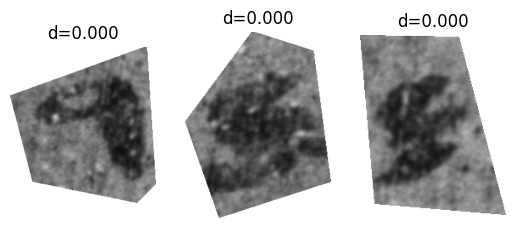

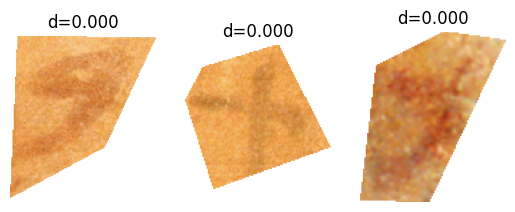

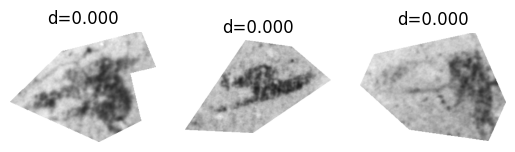

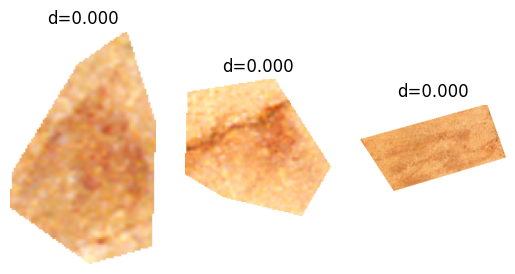

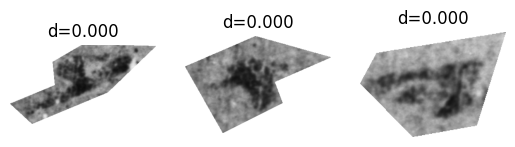

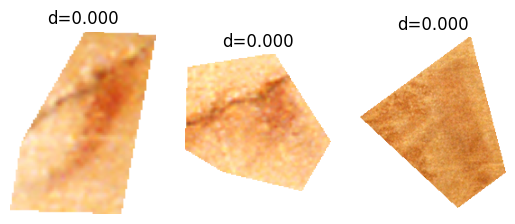

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset, SimCLRCollateFunction, collate
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    cnt=0 # only 10 embeding for testing
    with torch.no_grad():
        for img, label, fnames in dataloader:
            #import pdb; pdb.set_trace() #Debugger

            #if cnt ==9: # only 10 embeding for testing
              #break
            img = torch.squeeze(img, 1)  # remove the second dimension
            #print("img shape: ",img.shape)
            #print("label: ",label)
            #print("fnames: ",fnames)
            print()
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(list(label["sample_path"]))
            cnt+=1 # only 10 embeding for testing

    embeddings = torch.cat(embeddings, 0)

    embeddings = normalize(torch.Tensor.cpu(embeddings))
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader)


def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)
    
    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            # let's disable the axis
            plt.axis("off")
plot_knn_examples(embeddings, filenames)


# New Section